<a href="https://colab.research.google.com/github/kushalnavghare/DSC-478_PRG_ML_APP/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### drive env setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%pwd

'/content'

In [4]:

%cd drive/MyDrive/DSC-478_PRG_ML_APPS/

/content/drive/MyDrive/DSC-478_PRG_ML_APPS


In [5]:
# import libs
import pandas as pd
import numpy as np

In [6]:
pd.set_option('display.max_columns', 101)

In [7]:
import matplotlib.pyplot as plt

In [8]:
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score, silhouette_samples, silhouette_score

In [10]:
!pip install -qq yellowbrick

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

# PCA for Reduced Dimensionality in Clustering

For this problem you will use an image segmentation data set for clustering. You will experiment with using PCA as an approach to reduce dimensionality and noise in the data. You will compare the results of clustering the data with and without PCA using the provided image class assignments as the ground truth. The data set is divided into three files. The file "segmentation_data.txt" contains data about images with each line corresponding to one image. Each image is represented by 19 features (these are the columns in the data and correspond to the feature names in the file "segmentation_names.txt". The file "segmentation_classes.txt" contains the class labels (the type of image) and a numeric class label for each of the corresponding images in the data file. After clustering the image data, you will use the class labels to measure completeness and homogeneity of the generated clusters. The data set used in this problem is based on the Image Segmentation data set at the UCI Machine Learning Repository.

Your tasks in this problem are the following:

## a.
Load in the image data matrix (with rows as images and columns as features). Also load in the numeric class labels from the segmentation class file. Using your favorite method (e.g., sklearn's min-max scaler), perform min-max normalization on the data matrix so that each feature is scaled to [0,1] range.

In [12]:
# read data
raw_img_data = pd.read_table("data/segmentation_data.txt", header=None, sep=",")
raw_feat_names = pd.read_table("data/segmentation_names.txt", header=None, sep=',', names=['feat_names'])
raw_classes = pd.read_table("data/segmentation_classes.txt", header=None, sep='\t', names=['class', 'hh'])

In [13]:
raw_img_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
1,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
2,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902
3,47.0,232.0,9,0.0,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,1.875362
4,97.0,186.0,9,0.0,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,1.863654


In [14]:
raw_feat_names.head()

,feat_names
0,REGION-CENTROID-COL
1,REGION-CENTROID-ROW
2,REGION-PIXEL-COUNT
3,SHORT-LINE-DENSITY-5
4,SHORT-LINE-DENSITY-2


In [15]:
raw_classes.head()

,class,hh
0,GRASS,0
1,GRASS,0
2,GRASS,0
3,GRASS,0
4,GRASS,0


In [16]:
# remove - and replace with _
raw_feat_names.feat_names = raw_feat_names.feat_names.str.replace("-", "_")

In [17]:
# assign column names
raw_img_data.columns = raw_feat_names.feat_names

In [18]:
raw_img_data.head()

feat_names,REGION_CENTROID_COL,REGION_CENTROID_ROW,REGION_PIXEL_COUNT,SHORT_LINE_DENSITY_5,SHORT_LINE_DENSITY_2,VEDGE_MEAN,VEDGE_SD,HEDGE_MEAN,HEDGE_SD,INTENSITY_MEAN,RAWRED_MEAN,RAWBLUE_MEAN,RAWGREEN_MEAN,EXRED_MEAN,EXBLUE_MEAN,EXGREEN_MEAN,VALUE_MEAN,SATURATION_MEAN,HUE_MEAN
0,110.0,189.0,9,0.0,0.0,1.000000,0.666667,1.222222,1.186342,12.925926,10.888889,9.222222,18.666668,-6.111111,-11.111111,17.222221,18.666668,0.508139,1.910864
1,86.0,187.0,9,0.0,0.0,1.111111,0.720082,1.444444,0.750309,13.740741,11.666667,10.333334,19.222221,-6.222222,-10.222222,16.444445,19.222221,0.463329,1.941465
2,225.0,244.0,9,0.0,0.0,3.388889,2.195113,3.000000,1.520234,12.259259,10.333334,9.333334,17.111110,-5.777778,-8.777778,14.555555,17.111110,0.480149,1.987902
3,47.0,232.0,9,0.0,0.0,1.277778,1.254621,1.000000,0.894427,12.703704,11.000000,9.000000,18.111110,-5.111111,-11.111111,16.222221,18.111110,0.500966,1.875362
4,97.0,186.0,9,0.0,0.0,1.166667,0.691215,1.166667,1.005540,15.592592,13.888889,11.777778,21.111110,-5.111111,-11.444445,16.555555,21.111110,0.442661,1.863654


In [19]:
# define scaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1))

In [20]:
# scaled img_data

img_data_matrix = min_max_scaler.fit_transform(raw_img_data)

In [21]:
# convert into dataframe

scaled_img_data = pd.DataFrame(img_data_matrix, columns=raw_feat_names.feat_names)

In [22]:
scaled_img_data.describe()

feat_names,REGION_CENTROID_COL,REGION_CENTROID_ROW,REGION_PIXEL_COUNT,SHORT_LINE_DENSITY_5,SHORT_LINE_DENSITY_2,VEDGE_MEAN,VEDGE_SD,HEDGE_MEAN,HEDGE_SD,INTENSITY_MEAN,RAWRED_MEAN,RAWBLUE_MEAN,RAWGREEN_MEAN,EXRED_MEAN,EXBLUE_MEAN,EXGREEN_MEAN,VALUE_MEAN,SATURATION_MEAN,HUE_MEAN
count,2100.000000,2100.000000,2100.0,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,0.489883,0.468681,0.0,0.044762,0.020476,0.064705,0.005756,0.053816,0.005702,0.258272,0.239271,0.292968,0.239421,0.620323,0.359133,0.429304,0.299309,0.427259,0.281874
std,0.287979,0.239298,0.0,0.123071,0.106079,0.090666,0.045365,0.077589,0.038570,0.265854,0.255228,0.288359,0.254664,0.194578,0.208102,0.198222,0.284319,0.228458,0.259252
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.241107,0.291667,0.0,0.000000,0.000000,0.024715,0.000353,0.018634,0.000304,0.052091,0.051053,0.064065,0.043648,0.521922,0.177353,0.288425,0.078056,0.284934,0.143644
50%,0.474308,0.462500,0.0,0.000000,0.000000,0.043726,0.000840,0.032298,0.000714,0.151046,0.143436,0.184094,0.143414,0.651119,0.340000,0.390892,0.189985,0.375064,0.166461
75%,0.740119,0.667708,0.0,0.000000,0.000000,0.076046,0.001822,0.057143,0.001624,0.371418,0.345219,0.430781,0.325409,0.763060,0.514118,0.523719,0.430781,0.540228,0.248198
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## b.
Using the Kmeans implementation in scikit-learn, perform clustering on the image data (use K = 7 in your clustering so that later we can compare the clusters to the 7 pre-assigned image classes). Print the cluster centroids (use some formatting so that they are visually understandable). To evaluate your clusters, first perform Silhouette analysis on the clusters (compute Silhouette values for all instances in the data, and then compute the overall mean Silhouette value; optionally, you can provide a visualization of the Silhouettes). Next, compare your 7 clusters to the 7 pre-assigned classes by computing the Completeness and Homogeneity values of the generated clusters.

In [23]:
# define constant k
K = 7
RANDOM_STATE = 42

In [24]:
# define cluster

k_means = KMeans(n_clusters=K, random_state=RANDOM_STATE)

In [25]:
# cluster predict

cluster_labels = k_means.fit_predict(scaled_img_data)

In [26]:
# cluster centroids

cluster_centroids = k_means.cluster_centers_

In [27]:
# cluster centroids df

centroids_df = pd.DataFrame(cluster_centroids, columns=[i for i in range(19)])

In [28]:
centroids_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.256103,0.393468,0.0,0.074510,0.019118,0.077343,0.004100,0.060574,0.004967,0.148187,0.138085,0.185160,0.118539,0.716906,0.344014,0.355458,0.185413,0.411986,0.201890
1,0.535099,0.150167,0.0,0.027778,0.001667,0.030228,0.000543,0.026766,0.000587,0.823246,0.779716,0.894170,0.788761,0.270665,0.666373,0.289386,0.894170,0.211804,0.125066
2,0.513994,0.808937,0.0,0.077441,0.005051,0.054474,0.001407,0.046335,0.001401,0.108790,0.091403,0.092414,0.142676,0.679161,0.079002,0.821287,0.134901,0.414491,0.892333
3,0.302506,0.530862,0.0,0.052260,0.046610,0.100817,0.009420,0.083972,0.011043,0.400608,0.370347,0.472461,0.353036,0.497146,0.570882,0.213054,0.472461,0.302263,0.163879
4,0.750696,0.534564,0.0,0.040000,0.038462,0.114419,0.019301,0.109240,0.017999,0.300955,0.279908,0.352738,0.265920,0.592572,0.451124,0.309158,0.352822,0.302342,0.164764
5,0.770674,0.425215,0.0,0.013978,0.022581,0.040237,0.002989,0.023122,0.002088,0.041138,0.035005,0.058340,0.028766,0.778473,0.223939,0.486509,0.059295,0.538181,0.243969
6,0.254169,0.459974,0.0,0.026256,0.013699,0.037274,0.002364,0.027874,0.002017,0.026013,0.017925,0.042306,0.016504,0.769800,0.216011,0.508117,0.043295,0.801687,0.181153


In [29]:
# silhoutte values

silhouette_values = silhouette_samples(scaled_img_data, k_means.labels_)

In [30]:
mean_silhouette = np.mean(silhouette_values)

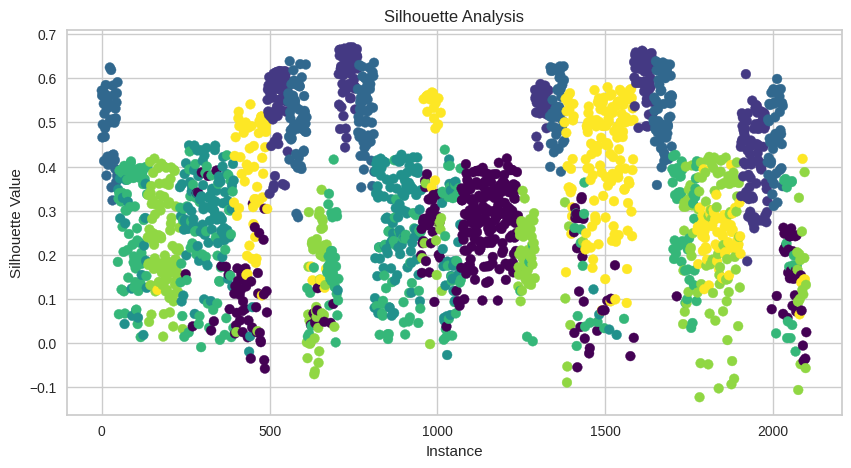

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(range(len(scaled_img_data)), silhouette_values, c=k_means.labels_, cmap='viridis')
plt.title('Silhouette Analysis')
plt.xlabel('Instance')
plt.ylabel('Silhouette Value')
plt.show()

In [32]:
completeness = completeness_score(raw_classes['class'], k_means.labels_)
homogeneity = homogeneity_score(raw_classes['class'], k_means.labels_)

In [33]:
print(f"Mean Silhouette: {mean_silhouette}")
print(f"Completeness: {completeness}")
print(f"Homogeneity: {homogeneity}")

Mean Silhouette: 0.332066475286672
Completeness: 0.613187012485301
Homogeneity: 0.6115021163370862


Text(0, 0.5, 'img feature 2')

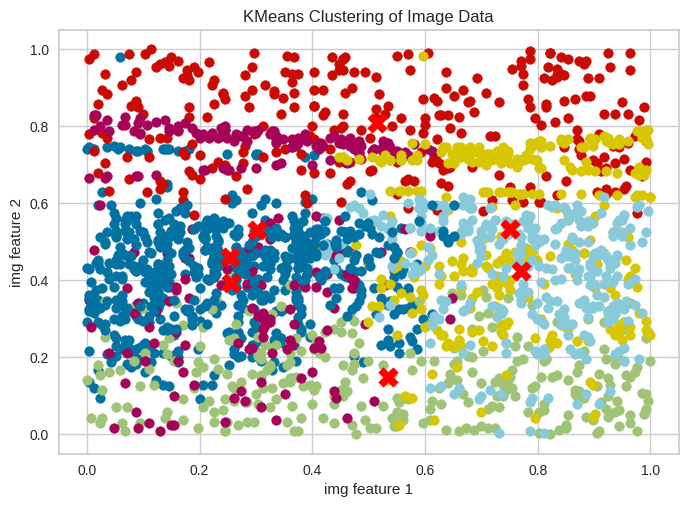

In [41]:
for i in range(K):
  cluster_points = img_data_matrix[k_means.labels_ == i]
  plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')

plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], marker='X', s=200, c='red', label='Centroids')

plt.title('KMeans Clustering of Image Data')
plt.xlabel('img feature 1')
plt.ylabel('img feature 2')

## c.
Do your own experiments with the number of clusters to see if a different value of K results in more cohesive clustering based on Silhouette analysis. Please do not provide all your clustering results, but you should include the best result according to your analysis and provide a brief discussion of why this particular clustering was selected.

In [69]:
for k in range(2, 11):
  k_means = KMeans(n_clusters=k, random_state=42)
  k_means.fit(scaled_img_data)

  # Silhouette analysis
  silhouette_values = silhouette_samples(scaled_img_data, k_means.labels_)
  mean_silhouette = np.mean(silhouette_values)
  completeness = completeness_score(raw_classes['class'], k_means.labels_)
  homogeneity = homogeneity_score(raw_classes['class'], k_means.labels_)

  print(f"Number of Clusters (K): {k}")
  print(f"Mean Silhouette: {mean_silhouette}")

  print(f"Completeness: {completeness}")
  print(f"Homogeneity: {homogeneity}")
  print("-" * 30)

Number of Clusters (K): 2
Mean Silhouette: 0.46317096004832026
Completeness: 0.8146269473259409
Homogeneity: 0.1955166887552262
------------------------------
Number of Clusters (K): 3
Mean Silhouette: 0.3214713024869174
Completeness: 0.805598474613619
Homogeneity: 0.40276468018712086
------------------------------
Number of Clusters (K): 4
Mean Silhouette: 0.38160981543092376
Completeness: 0.8399857755070813
Homogeneity: 0.5594575369803794
------------------------------
Number of Clusters (K): 5
Mean Silhouette: 0.348488349914882
Completeness: 0.7349006478538058
Homogeneity: 0.5902569740113445
------------------------------
Number of Clusters (K): 6
Mean Silhouette: 0.33372943972323865
Completeness: 0.6672987358060366
Homogeneity: 0.605636796111312
------------------------------
Number of Clusters (K): 7
Mean Silhouette: 0.332066475286672
Completeness: 0.613187012485301
Homogeneity: 0.6115021163370862
------------------------------
Number of Clusters (K): 8
Mean Silhouette: 0.33431474

K=2 has the highest mean silhouette score

*   Mean Silhouette: 0.46317096004832026
*   Completeness: 0.8146269473259409
*   Homogeneity: 0.1955166887552262

K=4 shows a good balance between mean silhouette score, completeness, and homogeneity.

*   Mean Silhouette: 0.38160981543092376
*   Completeness: 0.8399857755070813
*   Homogeneity: 0.5594575369803794

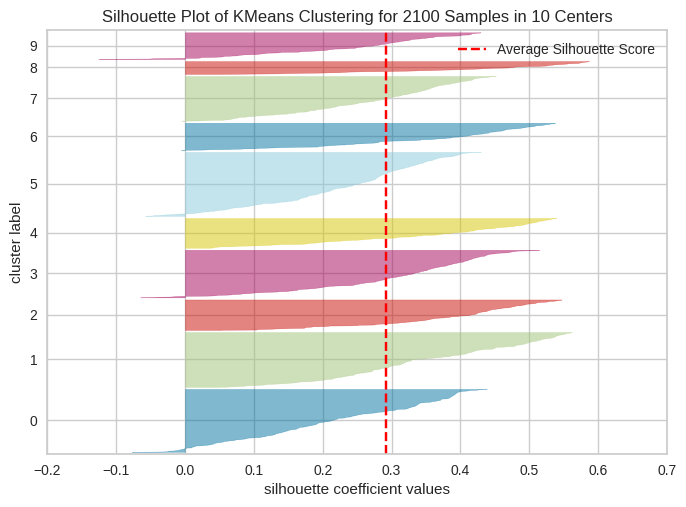

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2100 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [48]:
visualizer = SilhouetteVisualizer(k_means, colors='yellowbrick')
visualizer.fit(scaled_img_data)
visualizer.poof()

From the plot above, it looks like

## d.
Perform PCA on the normalized image data matrix. You may use the linear algebra package in Numpy or the Decomposition module in scikit-learn (the latter is much more efficient). Analyze the principal components to determine the number, r, of PCs needed to capture at least 95% of variance in the data. Provide a Scree plot of PC variances. Then use these r components as features to transform the data into a reduced dimension space.

In [49]:
from sklearn.decomposition import PCA

In [50]:
# define PCA

pca_decomp = PCA(random_state=RANDOM_STATE)

In [52]:
# fit

pca_decomp.fit(scaled_img_data)

PCA(random_state=42)

In [53]:
# get attributes

explained_variance_ratio = pca_decomp.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

In [62]:
print(f"Best number of components {np.argmax(cumulative_variance_ratio >= 0.95)}")

Best number of components 6


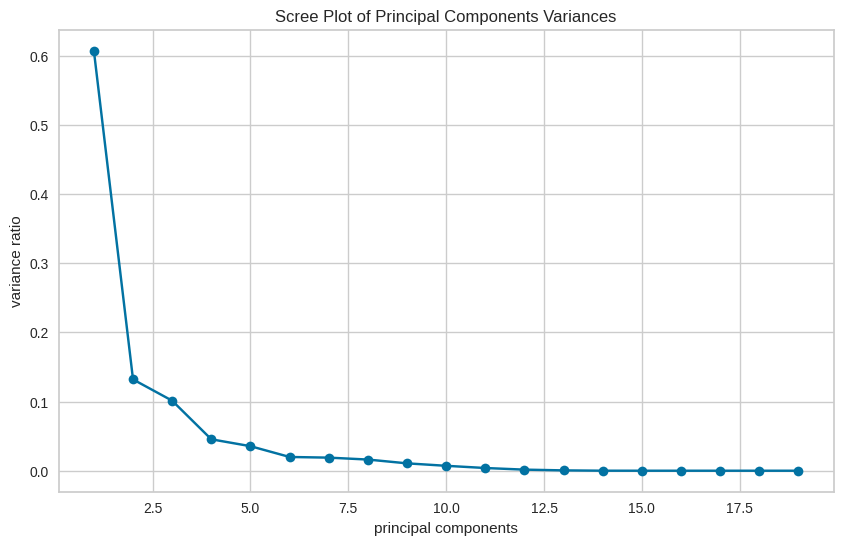

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.title('Scree Plot of Principal Components Variances')
plt.xlabel('principal components')
plt.ylabel('variance ratio')
plt.show()

In [65]:
# transform data into reduced dimension space

best_pca_comp = PCA(n_components=6, random_state=RANDOM_STATE)

In [66]:
# fit-transform

pca_img_data = best_pca_comp.fit_transform(scaled_img_data)

## e.
Perform Kmeans again, but this time on the lower dimensional transformed data. Then compare Silhouette values as well as completeness and Homogeneity values of the new clusters. Compare these results with those obtained on the full data in part b.

In [70]:
# fit kmeans on decomposed data

for k in range(2, 11):
  k_means = KMeans(n_clusters=k, random_state=42)
  k_means.fit(pca_img_data)

  # Silhouette analysis
  silhouette_values = silhouette_samples(pca_img_data, k_means.labels_)
  mean_silhouette = np.mean(silhouette_values)

  print(f"Number of Clusters (K): {k}")
  print(f"Mean Silhouette: {mean_silhouette}")
  completeness = completeness_score(raw_classes['class'], k_means.labels_)
  homogeneity = homogeneity_score(raw_classes['class'], k_means.labels_)
  print(f"Completeness: {completeness}")
  print(f"Homogeneity: {homogeneity}")
  print("-" * 30)

Number of Clusters (K): 2
Mean Silhouette: 0.48372255065106506
Completeness: 0.814626947325941
Homogeneity: 0.19551668875522624
------------------------------
Number of Clusters (K): 3
Mean Silhouette: 0.3483452761199816
Completeness: 0.8075845585437891
Homogeneity: 0.403318014924364
------------------------------
Number of Clusters (K): 4
Mean Silhouette: 0.41760799731328596
Completeness: 0.8439038482490108
Homogeneity: 0.5615373601726689
------------------------------
Number of Clusters (K): 5
Mean Silhouette: 0.3886127153114277
Completeness: 0.730967237735147
Homogeneity: 0.587586716217296
------------------------------
Number of Clusters (K): 6
Mean Silhouette: 0.36976148087472255
Completeness: 0.656954841162287
Homogeneity: 0.5942106961467897
------------------------------
Number of Clusters (K): 7
Mean Silhouette: 0.3763373394020104
Completeness: 0.6114496326215515
Homogeneity: 0.6098466687318066
------------------------------
Number of Clusters (K): 8
Mean Silhouette: 0.38269198

Best number of K given all metrics for decomposed data:

**Number of Clusters (K): 4**
*  Mean Silhouette: 0.41760799731328596
*  Completeness: 0.8439038482490108
*  Homogeneity: 0.5615373601726689

Previous experiment with scaled data,
K=4
*  Mean Silhouette: 0.38160981543092376
*  Completeness: 0.8399857755070813
*  Homogeneity: 0.5594575369803794

Completeness, Homogeneity and Mean silhouette improved by decomposing the image data with 6 components.

# Item-Based Joke Recommendation [Dataset: [jokes.zip](http://facweb.cs.depaul.edu/mobasher/classes/CSC478/Data/jokes.zip)]

For this problem you will use a modified version of the item-based recommender algorithm from Ch. 14 of Machine Learning in Action and use it on joke ratings data based on Jester Online Joke Recommender System. The modified version of the code is provided in the module itemBasedRec.py. Most of the module will be used as is, but you will add some additional functionality.

The data set contains two files. The file "modified_jester_data.csv" contains the ratings on 100 jokes by 1000 users (each row is a user profile). The ratings have been normalized to be between 1 and 21 (a 20-point scale), with 1 being the lowest rating. A zero indicated a missing rating. The file "jokes.csv" contains the joke ids mapped to the actual text of the jokes.

Your tasks in this problem are the following (please also see comments for the function stubs in the provided module):

## a.
Load in the joke ratings data and the joke text data into appropriate data structures. Use the "recommend" function to provide top 5 joke recommendations for users with id 4 using both Pearson and cosine similarity measures. Note the differences. Use the standard item-based collaborative filtering (based on the rating prediction function "standEst"). Next, find the top 5 recommendations for user with id 25 only with Pearson similarity using both the standard estimator and the SVD-based version (using "svdEst" as the prediction engine) to generate these recommendations. Note the differences. When outputting recommendations, you should show both the id and the text of the recommended jokes (in decreasing order of predicted rating) as well as the predicted ratings for each.

In [87]:
%pwd

'/content/drive/MyDrive/DSC-478_PRG_ML_APPS'

In [88]:
%cd code/

/content/drive/MyDrive/DSC-478_PRG_ML_APPS/code


In [90]:
from itemBasedRec import *

In [101]:
# read data
raw_jokes = load_jokes('../data/jokes.csv')
raw_jester = np.genfromtxt('../data/modified_jester_data.csv',delimiter=',')

In [102]:
len(raw_jokes), len(raw_jester)

(100, 1000)

In [103]:
raw_jokes[:2]

array(['A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer\'s disease". The man replies "Well thank God I don\'t have cancer!"',
       'This couple had an excellent relationship going until one day he came home from work to find his girlfriend packing. He asked her why she was leaving him and she told him that she had heard awful things about him. "What could they possibly have said to make you move out?" "They told me that you were a pedophile." He replied "That\'s an awfully big word for a ten year old."'],
      dtype='<U1198')

In [105]:
raw_jester[:2]

array([[ 3.18, 19.79,  1.34,  2.84,  3.48,  2.5 ,  1.15, 15.17,  2.02,
         6.24,  2.5 ,  4.25,  3.82, 19.45,  3.82,  3.48,  3.57,  1.19,
         1.15,  1.15,  1.63, 12.5 ,  6.63,  1.19,  2.5 , 12.12, 18.82,
        13.86, 20.13,  3.57, 13.14,  6.92,  1.92, 18.82, 16.05, 15.95,
         1.83,  2.6 ,  2.6 ,  2.6 ,  2.89,  1.87,  1.97,  1.92,  3.86,
         4.74, 14.79, 10.9 , 14.93, 15.13,  2.31,  3.86, 14.2 , 19.3 ,
         6.44, 11.92,  1.87,  1.58, 13.82,  2.36, 19.59, 14.59,  4.16,
         1.97, 13.82,  9.64,  1.92, 19.3 , 16.68,  6.19,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.58,  0.  ,  0.  ,  0.  ,
         3.28,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        13.82,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  5.37,  0.  ,  0.  ,
         0.  ],
       [15.08, 10.71, 17.36, 15.37,  8.62,  1.34, 10.27,  5.66, 19.88,
        20.22, 17.75, 19.64, 15.42, 18.43, 15.56, 10.03, 15.66, 10.32,
        14.3 ,  9.79, 11.87, 19.64, 19.35, 20.17, 11.05, 18.5

In [107]:
# pearson
recommend(raw_jester, 4, N=5, simMeas=pearsonSim, estMethod=standEst)

AttributeError: ignored

In [ ]:
# cosine
recommend(dataMat, 4, N=5, simMeas=cosineSim, estMethod=standEst):